In [64]:
include("../src/HPFEM.jl")

HPFEM

In [178]:
TF = Complex{Float64}
λ = one(TF) +im
ζ = -1.0 + im*2*one(TF)
nel = 150
nnodes = nel + 1
idir = [1,nnodes]
M = 5
Q = M+2
#b = HPFEM.Lagrange1d(M, TF)
b = HPFEM.ModalC01d(M, TF)
quad = HPFEM.QuadType(Q, HPFEM.GLJ, TF)
bas = HPFEM.Basis1d(b,quad, TF)
#bas = HPFEM.SEM1d(M, TF)
#bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [179]:
k = 2
uexact(x) = ζ*sin(2π*k*x)
rhsfun(x) = ζ * sin(2π*k*x) * (λ + (2π*k)^2)


rhsfun (generic function with 1 method)

In [180]:
uexact(1.7)

-0.5877852522924738 + 1.1755705045849476im

In [181]:
a = 1.3
b = 6.7
nodes = [TF(x) for x in linspace(a, b, nnodes)];

In [182]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [183]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix1d, TF);

In [184]:
for e = 1:nel
    Ae = zeros(TF, M, M)
    HPFEM.add_stiff_matrix!(bas, elems[e], Ae)
    HPFEM.add_mass_matrix!(bas, elems[e], Ae, λ)
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [185]:
Fe = zeros(TF, HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = rhsfun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
bnd = HPFEM.bndidx(lmap)
Fe[bnd[1],1] = uexact(TF(a));
Fe[bnd[2],nel] = uexact(TF(b));

In [186]:
HPFEM.solve!(solver, Fe);

In [187]:
nξ = 101
ξ = Complex{Float64}[TF(y) for y in linspace(-1,1,nξ)]
ϕ = zeros(TF, nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;

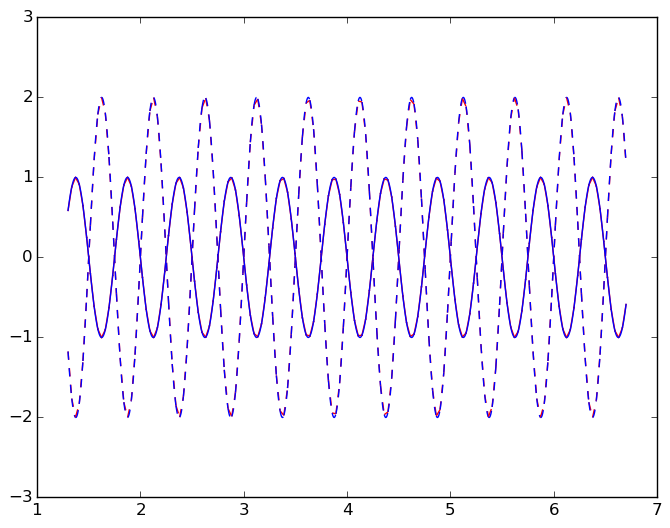

0.056725716042996296

In [177]:
using PyPlot
maxerr = 0.0
for e = 1:nel
    el = elems[e]
    x = (1-ξ)*el.a/2 + (1+ξ)*el.b/2 
    uu = uexact(x)
    
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(real(x), real(Ue[:,e]), "r", x, real(uu), "b")
    plot(real(x), imag(Ue[:,e]), "r--", real(x), imag(uu), "b--")
end
maxerr